# Programme 2: Coin Segmentation using Marker-Controlled Watershed 

**Objective:** Segment overlapping coins using marker-controlled watershed segmentation


In [28]:
# Import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['image.cmap'] = 'gray'

## Step 1: Load the Image 

Image loaded successfully!
Image shape: (322, 332, 3)
Image dtype: uint8


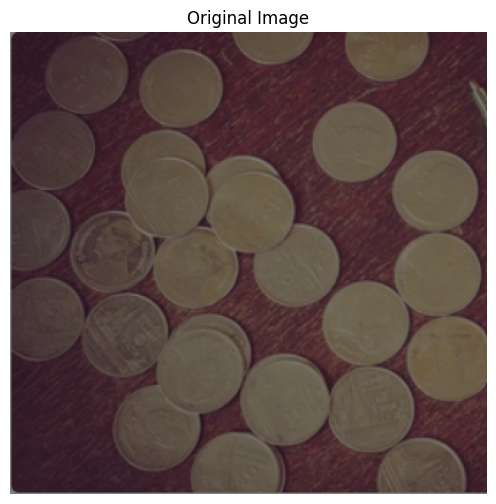

In [29]:
# Load the image
img_path = 'prog2.png'
img = cv2.imread(img_path)

if img is None:
    print(f"Error: Could not load image from {img_path}")
else:
    print(f"Image loaded successfully!")
    print(f"Image shape: {img.shape}")
    print(f"Image dtype: {img.dtype}")
    
    # Display original image
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

## Step 2: Convert to Grayscale and Apply OTSU Thresholding 

OTSU threshold value: 71.0


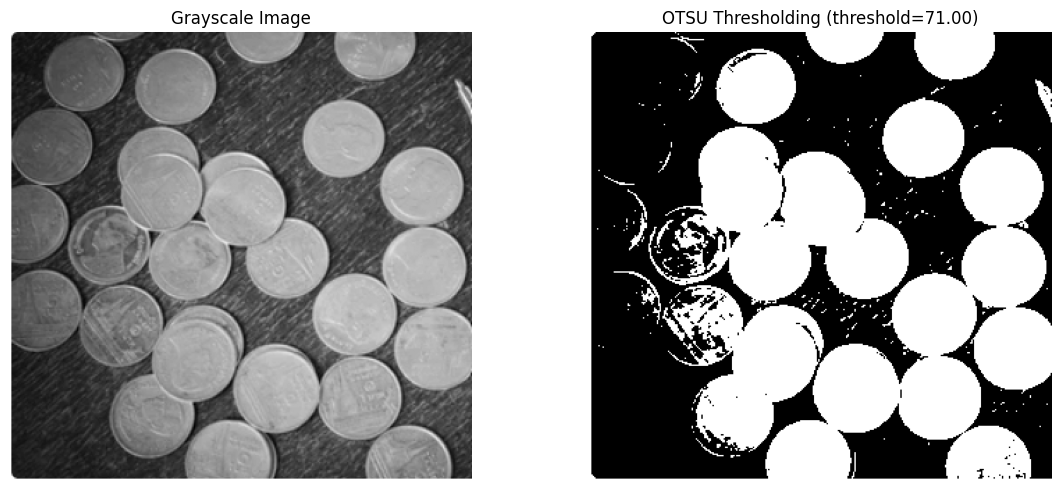

In [30]:
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply OTSU's thresholding
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

print(f"OTSU threshold value: {ret}")

# Display results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(gray, cmap='gray')
axes[0].set_title('Grayscale Image')
axes[0].axis('off')

axes[1].imshow(thresh, cmap='gray')
axes[1].set_title(f'OTSU Thresholding (threshold={ret:.2f})')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## Step 3: Remove Noise using Morphological Operations 

In [31]:
# Create kernel for morphological operations
kernel = np.ones((3, 3), np.uint8)

# Apply morphological opening 
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)



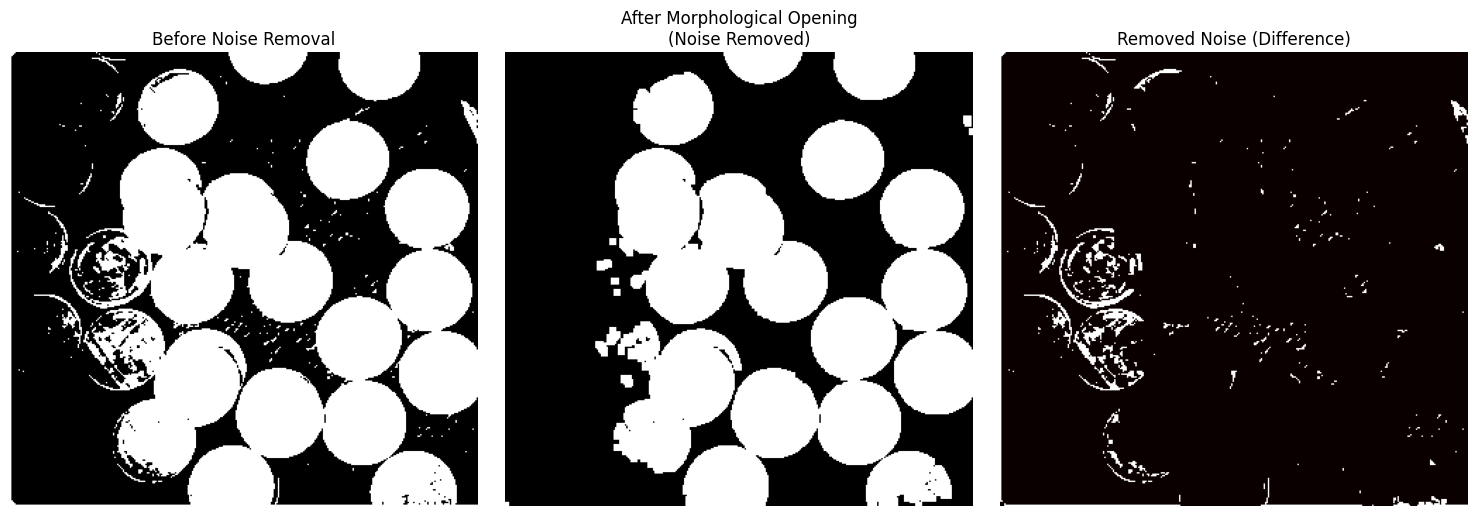

In [32]:

# Display results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(thresh, cmap='gray')
axes[0].set_title('Before Noise Removal')
axes[0].axis('off')

axes[1].imshow(opening, cmap='gray')
axes[1].set_title('After Morphological Opening\n(Noise Removed)')
axes[1].axis('off')

# Show difference
diff = cv2.absdiff(thresh, opening)
axes[2].imshow(diff, cmap='hot')
axes[2].set_title('Removed Noise (Difference)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Step 4: Extract Sure Background Area 

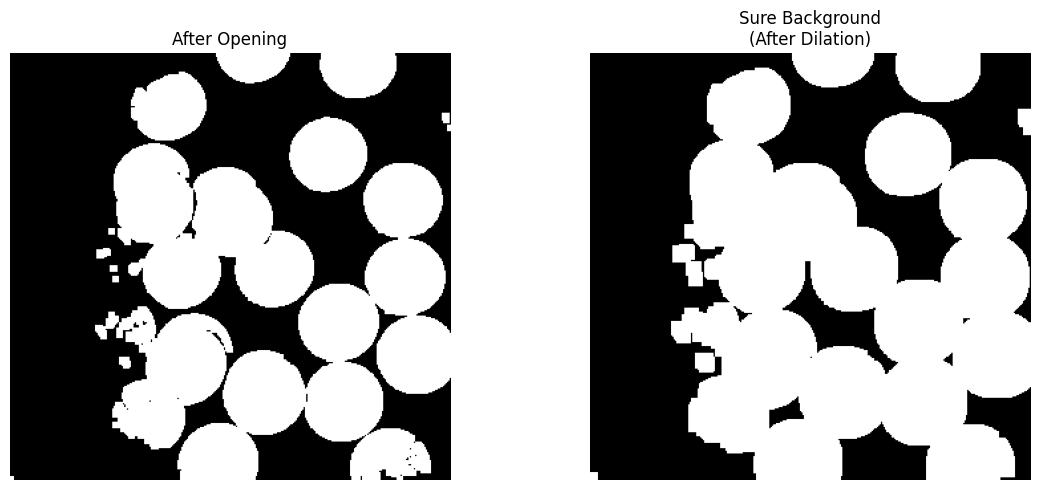

In [33]:
# Sure background area - dilate the opening result

sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Display results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(opening, cmap='gray')
axes[0].set_title('After Opening')
axes[0].axis('off')

axes[1].imshow(sure_bg, cmap='gray')
axes[1].set_title('Sure Background\n(After Dilation)')
axes[1].axis('off')

plt.tight_layout()
plt.show()


## Step 5: Extract Sure Foreground using Distance Transform 

In [34]:
# Apply distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

# Normalize for visualization
dist_transform_normalized = cv2.normalize(dist_transform, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# Threshold the distance transform to get sure foreground
# We take a percentage of the maximum distance
ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)


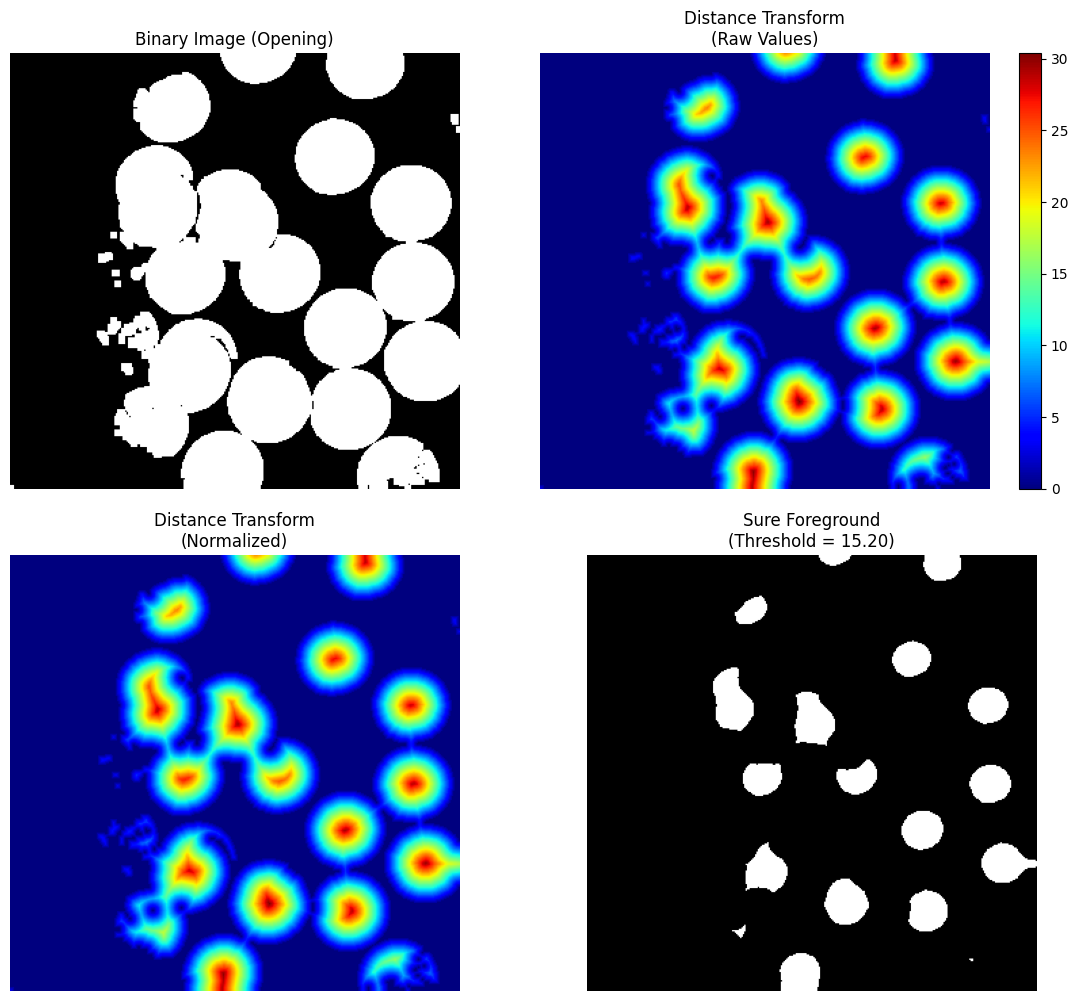

In [35]:

# Display results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(opening, cmap='gray')
axes[0, 0].set_title('Binary Image (Opening)')
axes[0, 0].axis('off')

axes[0, 1].imshow(dist_transform, cmap='jet')
axes[0, 1].set_title('Distance Transform\n(Raw Values)')
axes[0, 1].axis('off')
axes[0, 1].colorbar = plt.colorbar(axes[0, 1].imshow(dist_transform, cmap='jet'), ax=axes[0, 1])

axes[1, 0].imshow(dist_transform_normalized, cmap='jet')
axes[1, 0].set_title('Distance Transform\n(Normalized)')
axes[1, 0].axis('off')

axes[1, 1].imshow(sure_fg, cmap='gray')
axes[1, 1].set_title(f'Sure Foreground\n(Threshold = {0.5 * dist_transform.max():.2f})')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


## Step 6: Find Unknown Region 

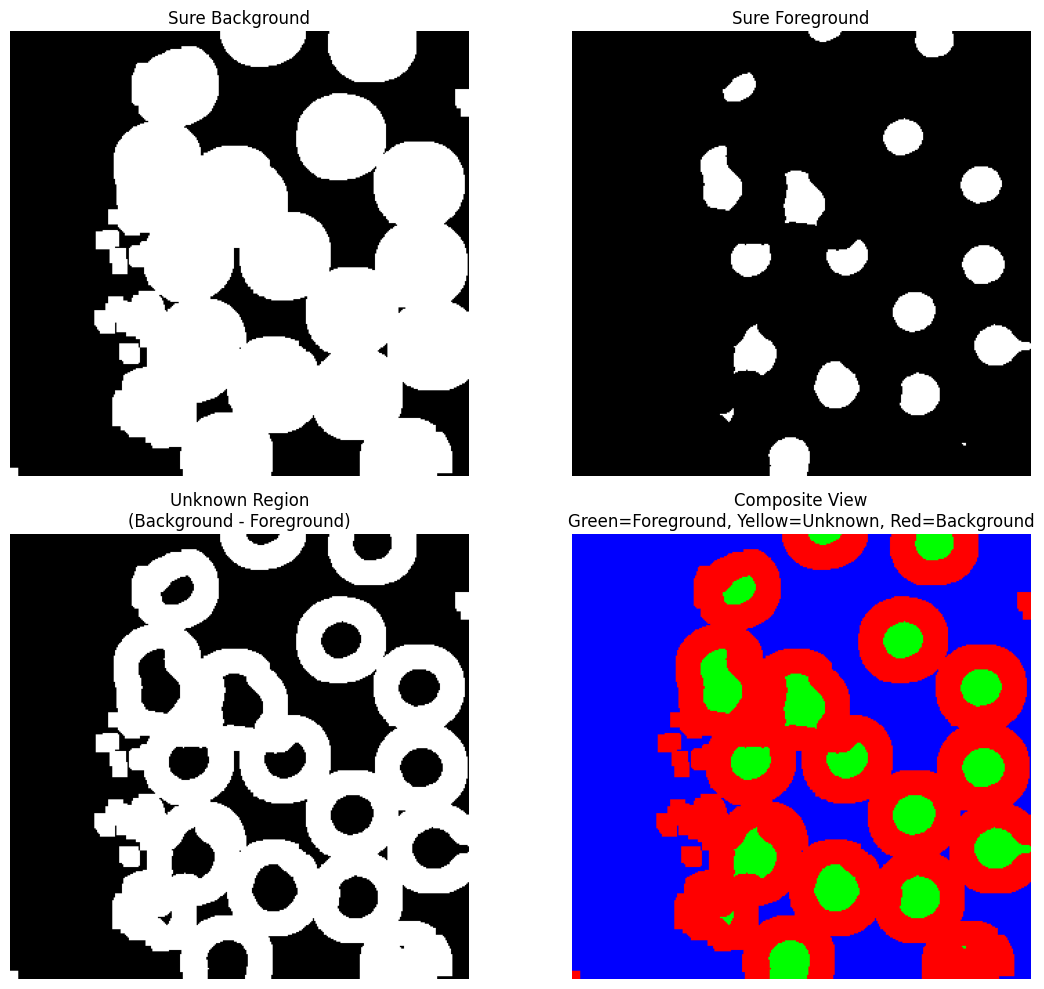

In [36]:
# Unknown region = Sure background - Sure foreground
unknown = cv2.subtract(sure_bg, sure_fg)

# Display all regions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(sure_bg, cmap='gray')
axes[0, 0].set_title('Sure Background')
axes[0, 0].axis('off')

axes[0, 1].imshow(sure_fg, cmap='gray')
axes[0, 1].set_title('Sure Foreground')
axes[0, 1].axis('off')

axes[1, 0].imshow(unknown, cmap='gray')
axes[1, 0].set_title('Unknown Region\n(Background - Foreground)')
axes[1, 0].axis('off')

# Create a composite view
composite = np.zeros_like(img)
composite[sure_fg == 255] = [0, 255, 0]  
composite[unknown == 255] = [0,0 , 255]  # Yellow for unknown
composite[sure_bg == 0] = [255, 0, 0]  # Red for sure background

axes[1, 1].imshow(cv2.cvtColor(composite, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title('Composite View\nGreen=Foreground, Yellow=Unknown, Red=Background')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## Step 7: Marker Labelling and Watershed Segmentation 

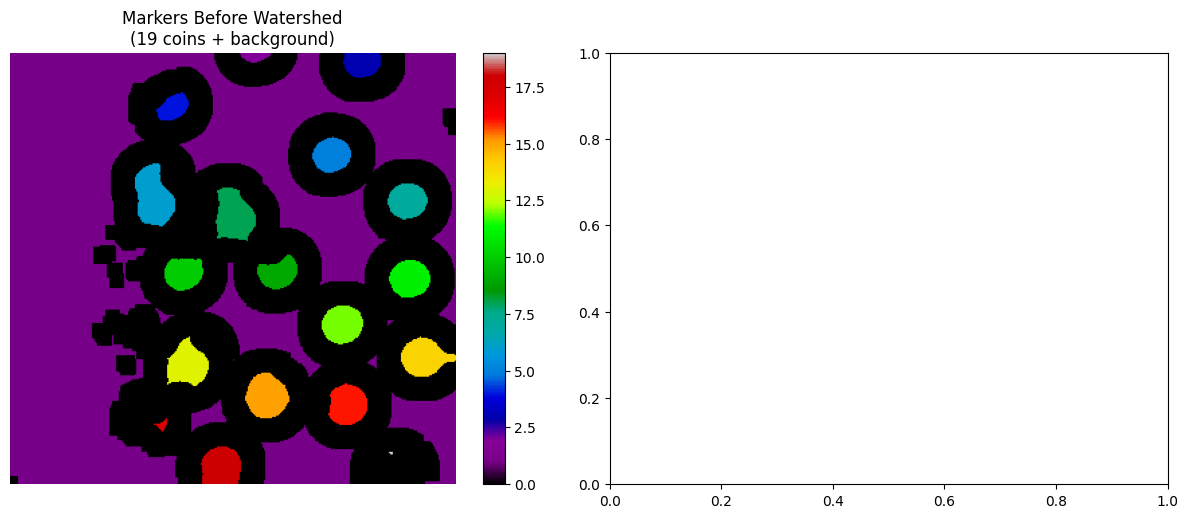

In [40]:
# Marker labelling
# Label the sure foreground regions
ret, markers = cv2.connectedComponents(sure_fg)

# Add 1 to all labels so that sure background is not 0, but 1
markers = markers + 1

# Mark the unknown region as 0
markers[unknown == 255] = 0

# Display markers
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(markers, cmap='nipy_spectral')
axes[0].set_title(f'Markers Before Watershed\n({ret} coins + background)')
axes[0].axis('off')

# Create a colorbar
im = axes[0].imshow(markers, cmap='nipy_spectral')
plt.colorbar(im, ax=axes[0])



plt.tight_layout()
plt.show()

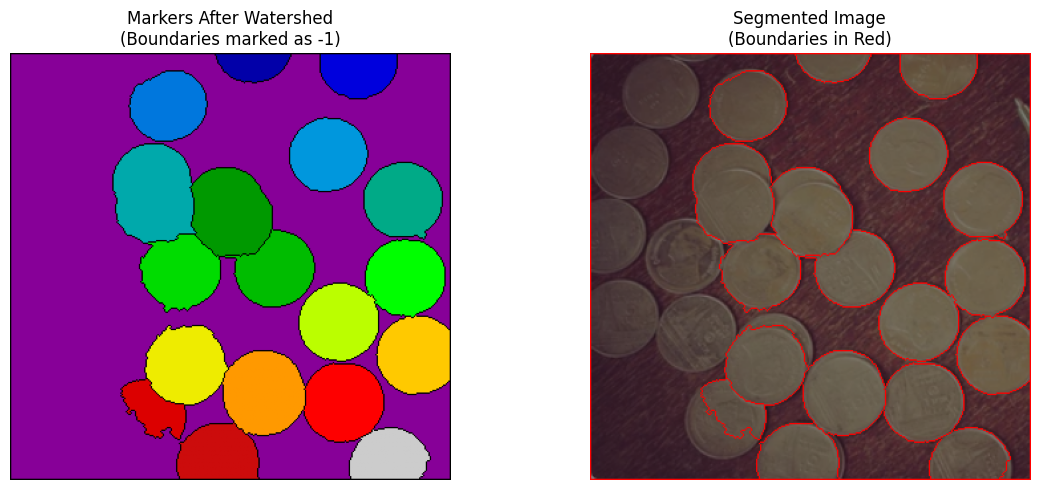

Watershed segmentation complete!
Number of segments: 18


In [38]:
# Apply watershed algorithm
markers_watershed = cv2.watershed(img, markers)

# Create output image
img_result = img.copy()

# Mark boundaries in red
img_result[markers_watershed == -1] = [0, 0, 255]

# Display results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(markers_watershed, cmap='nipy_spectral')
axes[0].set_title('Markers After Watershed\n(Boundaries marked as -1)')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
axes[1].set_title('Segmented Image\n(Boundaries in Red)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Watershed segmentation complete!")
print(f"Number of segments: {len(np.unique(markers_watershed)) - 2}")  # -2 for background and boundary

## Step 9: Why Direct Watershed Causes Over-segmentation 


Direct watershed on the grayscale image is likely to cause over-segmentation in this scenario due to the following reasons:

1. **Noise Sensitivity**: The grayscale image contains noise and small intensity variations. Direct watershed treats every local minimum as a separate catchment basin, leading to many small regions.

2. **Surface Reflections**: Coins have bright spots due to surface reflections. These create local intensity peaks that the watershed algorithm interprets as separate regions.

3. **No Prior Information**: Direct watershed has no information about what constitutes a "coin" versus "noise", so it segments every intensity variation.


## Step 10: Why Thresholding Alone Cannot Separate Overlapping Coins 


Thresholding alone cannot separate overlapping coins because:

1. **Binary Decision**: Thresholding only creates a binary image (foreground/background) based on intensity values. It cannot distinguish between individual objects that have similar intensities.

2. **Connected Components**: When coins touch or overlap, they form a single connected component in the binary image. Thresholding sees this as one large object, not multiple coins.

3. **No Spatial Information**: Thresholding doesn't use spatial relationships or shape information to separate objects.

4. **Uniform Intensity**: Overlapping coins have similar intensity values, so there's no intensity-based boundary between them that thresholding can detect.


## Step 11: Preprocessing Pipeline for Watershed Segmentation 

Complete Preprocessing Pipeline:

1. Grayscale Conversion
2. Noise Reduction 
3. Thresholding (OTSU)
4. Morphological Opening
5. Sure Background Extraction
6. Sure Foreground Extraction
7. Unknown Region Identification
8. Marker Creation
   


## Step 12: Generating Internal and Background Markers 

### Internal Markers (Foreground):
1. Distance Transform: Apply distance transform to the binary image
2. Thresholding: Threshold the distance transform
3. Connected Components: Label each connected region

### Background Markers:
1. Dilation: Dilate the binary image
2. Inversion: Invert to get background region
  
### Unknown Region:
- Subtraction: Background - Foreground markers
- This is where watershed algorithm will determine boundaries

